In [1]:
import numpy as np
import cv2
import re
from matplotlib import pyplot as plt


In [ ]:
def blur(image):
    height, width, channels = image.shape
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image_size = gray.size

    gray = cv2.GaussianBlur(gray, (3, 3), 2)
    threshold = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    threshold = cv2.fastNlMeansDenoising(threshold, 11, 31, 9)
    return threshold

In [ ]:
def biggest_contour(contours, min_area):
    contour_subset = []

    for cnt in contours:
        hull = cv2.convexHull(cnt)
        contour_subset.append(cv2.approxPolyDP(hull, 0.001 * cv2.arcLength(hull, True), True))
    contour_subset = np.array(contour_subset)
    
    biggest = None
    max_area = 0
    biggest_n = 0
    approx_contour = None
    for n, i in enumerate(contour_subset):
        area = cv2.contourArea(i)

        if area > min_area / 40:
            peri = cv2.arcLength(i, True)
            approx = cv2.approxPolyDP(i, 0.02 * peri, True)
            if area > max_area and len(approx) == 4:
                biggest = approx
                max_area = area
                biggest_n = n
                approx_contour = approx

    return biggest_n, approx_contour, contour_subset

In [ ]:
def crop_image(image, contour_subset, biggest_n, approx_contour):
    threshold = cv2.drawContours(image, contour_subset, biggest_n, (0, 255, 0), 1)
    dst = 0
    if approx_contour is not None and len(approx_contour) == 4:
        approx_contour = np.float32(approx_contour)

        # Correctly order the poitns in the contour
        approx_contour = approx_contour.reshape(4, 2)
        rect = np.zeros((4, 2), dtype="float32")

        s = approx_contour.sum(axis=1)
        rect[0] = approx_contour[np.argmin(s)]
        rect[2] = approx_contour[np.argmax(s)]

        diff = np.diff(approx_contour, axis=1)
        rect[1] = approx_contour[np.argmin(diff)]
        rect[3] = approx_contour[np.argmax(diff)]

        
        # Crop based on points with a bit of padding
        (tl, tr, br, bl) = rect

        widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
        widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
        maxWidth = max(int(widthA), int(widthB))

        heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
        heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
        maxHeight = max(int(heightA), int(heightB))

        dst = np.array([
            [0, 0],
            [maxWidth - 1, 0],
            [maxWidth - 1, maxHeight - 1],
            [0, maxHeight - 1]], dtype="float32")

        # Remove shear effect
        M = cv2.getPerspectiveTransform(rect, dst)
        dst = cv2.warpPerspective(threshold, M, (maxWidth, maxHeight))
        
        

    return dst

In [ ]:
def sharpen_image(cropped_image):
    #Sharpen using filter
    kernel_sharpening = np.array([[0, -1, 0],
                                  [-1, 5, -1],
                                  [0, -1, 0]])
    sharpened = cv2.filter2D(cropped_image, -1, kernel_sharpening)
    
    #Increase brightness
    increase_value = 30
    hsv = cv2.cvtColor(sharpened, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    lim = 255 - increase_value
    v[v > lim] = 255
    v[v <= lim] += increase_value
    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    
    return img
    


In [ ]:
refFilename = "./temp_data/0.jpg"
image = cv2.imread(refFilename)

# scale_percent = 50 # percent of original size
# width = int(image.shape[1] * scale_percent / 100)
# height = int(image.shape[0] * scale_percent / 100)
# dim = (width, height)
  
# # resize image
# image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)

#1. Blur
blured_image = blur(image)

#2. Canny Edge detection
edges = cv2.Canny(blured_image, 50, 150, apertureSize=7)

# 3. Find Contours
contours, hierarchy = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 4. Get largest contour (and crop)
biggest_n, approx_contour, contour_subset = biggest_contour(contours, min_area=image.size)

# 5. Crop Image
cropped_image = crop_image(image, contour_subset, biggest_n, approx_contour)

# 6. Sharpen and increase brightness
sharpened_image = sharpen_image(cropped_image)


f, axarr = plt.subplots(1,2, figsize=(10,7))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
im_clean = cv2.cvtColor(sharpened_image, cv2.COLOR_BGR2RGB)
axarr[0].imshow(image)
axarr[0].title.set_text('Original')

axarr[1].imshow(im_clean)
axarr[1].title.set_text('Aligned')

In [ ]:
refFilename = "./temp_data/0.jpg"
image = cv2.imread(refFilename)

In [24]:
import cv2
import numpy as np
 
# Read Image to be aligned
imgTest = cv2.imread("./temp_data/0.jpg")
# Reference Reference image or Ideal image
imgRef = cv2.imread("./temp_data/1.jpg")

In [25]:
# Convert to grayscale.
imgTest_grey = cv2.cvtColor(imgTest, cv2.COLOR_BGR2GRAY)
imgRef_grey = cv2.cvtColor(imgRef, cv2.COLOR_BGR2GRAY)
height, width = imgRef_grey.shape

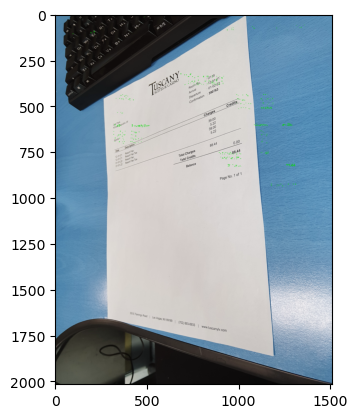

In [26]:
# Configure ORB feature detector Algorithm with 1000 features.
orb_detector = cv2.ORB_create(1000)
 
# Extract key points and descriptors for both images
keyPoint1, des1 = orb_detector.detectAndCompute(imgTest_grey, None)
keyPoint2, des2 = orb_detector.detectAndCompute(imgRef_grey, None)
 
# Display keypoints for reference image in green color
imgKp_Ref = cv2.drawKeypoints(imgRef, keyPoint1, 0, (0,222,0), None)
imgKp_Ref = cv2.resize(imgKp_Ref, (width//2, height//2))
 
#cv2.imshow('Key Points', imgKp_Ref)
#cv2.waitKey(0)

plt.imshow(imgKp_Ref)

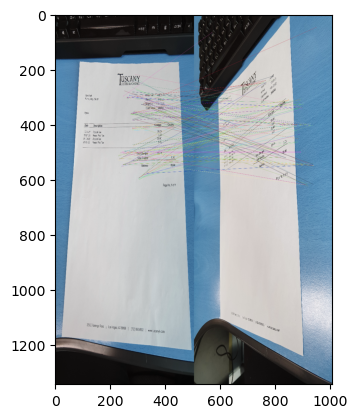

In [27]:
# Match features between two images using Brute Force matcher with Hamming distance
matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
 
# Match the two sets of descriptors.
matches = matcher.match(des1, des2)
 
# Sort matches on the basis of their Hamming distance.
#matches.sort(key=lambda x: x.distance)
 
# Take the top 90 % matches forward.
matches = matches[:int(len(matches) * 0.9)]
no_of_matches = len(matches)
 
# Display only 100 best matches {good[:100}
imgMatch = cv2.drawMatches(imgTest, keyPoint2, imgRef, keyPoint1, matches[:100], None, flags = 2)
imgMatch = cv2.resize(imgMatch, (width//3, height//3))
 
#cv2.imshow('Image Match', imgMatch)
#cv2.waitKey(0)

plt.imshow(imgMatch)

In [28]:
# Define 2x2 empty matrices
p1 = np.zeros((no_of_matches, 2))
p2 = np.zeros((no_of_matches, 2))
 
# Storing values to the matrices
for i in range(len(matches)):
    p1[i, :] = keyPoint1[matches[i].queryIdx].pt
    p2[i, :] = keyPoint2[matches[i].trainIdx].pt
 
# Find the homography matrix.
homography, mask = cv2.findHomography(p1, p2, cv2.RANSAC)


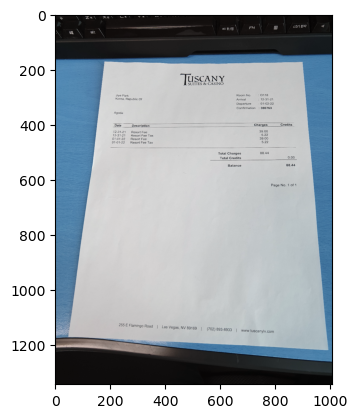

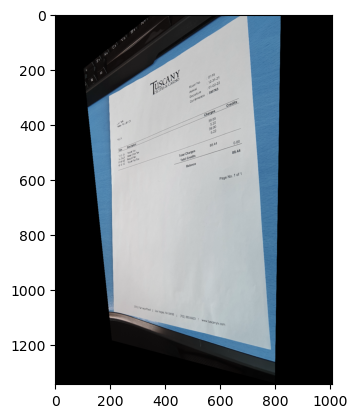

In [29]:
# Use homography matrix to transform the unaligned image wrt the reference image.
aligned_img = cv2.warpPerspective(imgTest, homography, (width, height))
# Resizing the image to display in our screen (optional)
aligned_img = cv2.resize(aligned_img, (width//3, height//3))
 
# Copy of input image
imgTest_cp = imgTest.copy()
imgTest_cp = cv2.resize(imgTest_cp, (width//3, height//3))
# Save the align image output.
# cv2.imwrite('output.jpg', aligned_img)
 
#cv2.imshow('Input Image', imgTest_cp)
#cv2.imshow('Output Image', aligned_img)
#cv2.waitKey(0)

plt.imshow(imgTest_cp)
plt.show()
plt.imshow(aligned_img)
plt.show()

In [119]:
def sharpen_image(cropped_image):
    #Sharpen using filter
    kernel_sharpening = np.array([[0, -1, 0],
                                  [-1, 5, -1],
                                  [0, -1, 0]])
    sharpened = cv2.filter2D(cropped_image, -1, kernel_sharpening)
    
    #Increase brightness
    increase_value = 50
    hsv = cv2.cvtColor(sharpened, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    lim = 255 - increase_value
    v[v > lim] = 255
    v[v <= lim] += increase_value
    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2RGB)
    
    return img
    


In [120]:
refFilename = "./DocGeoNet/rec/0_rec.png"
image = cv2.imread(refFilename)

image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)


In [121]:
sharpened_image = sharpen_image(image)

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

img_en = Image.fromarray(image)
enhancer = ImageEnhance.Contrast(img_en)
factor = 2.0
img_en = enhancer.enhance(factor)

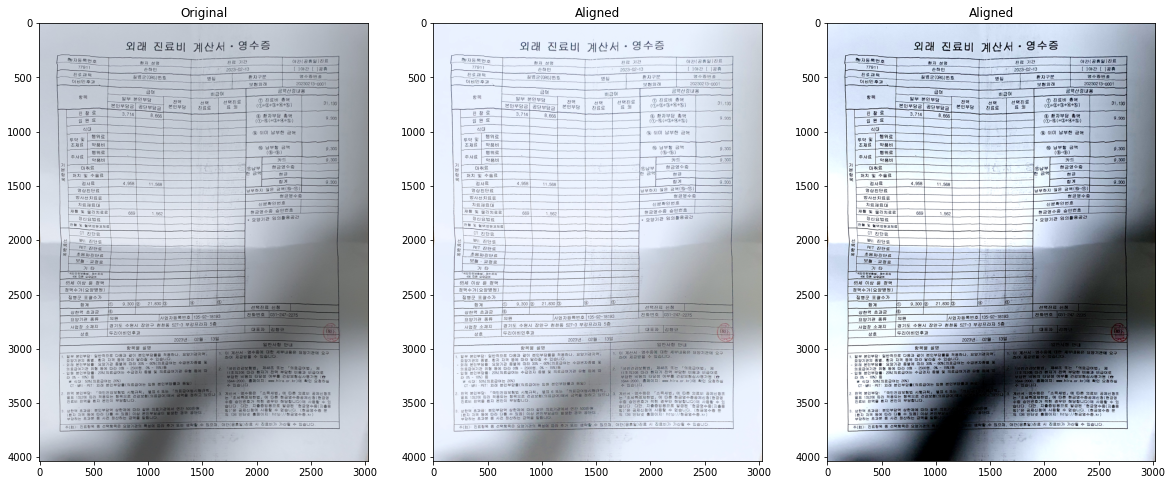

In [122]:
f, axarr = plt.subplots(1,3, figsize=(20,14))

axarr[0].imshow(image)
axarr[0].title.set_text('Original')

axarr[1].imshow(sharpened_image)
axarr[1].title.set_text('Aligned')

axarr[2].imshow(img_en)
axarr[2].title.set_text('Aligned')

In [19]:
sharpened_imageimage = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
cv2.imwrite("./DocGeoNet/rec/0_rec_alined.png", sharpened_image)


True

In [83]:
import os
import cv2
import numpy as np

import skimage
from skimage import io
from skimage import transform as tf
from skimage.filters.rank import mean_bilateral
from skimage import morphology

from PIL import Image
from PIL import ImageEnhance

import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision import transforms
from collections import OrderedDict

import argparse

from DocProj.model_illNet import illNet

In [84]:

def preProcess(img):
    
    img[:,:,0] = mean_bilateral(img[:,:,0], morphology.disk(20), s0=10, s1=10)
    img[:,:,1] = mean_bilateral(img[:,:,1], morphology.disk(20), s0=10, s1=10)
    img[:,:,2] = mean_bilateral(img[:,:,2], morphology.disk(20), s0=10, s1=10)
    
    return img
    

def padCropImg(img):
    
    H = img.shape[0]
    W = img.shape[1]

    patchRes = 128
    pH = patchRes
    pW = patchRes
    ovlp = int(patchRes * 0.125)

    padH = (int((H - patchRes)/(patchRes - ovlp) + 1) * (patchRes - ovlp) + patchRes) - H
    padW = (int((W - patchRes)/(patchRes - ovlp) + 1) * (patchRes - ovlp) + patchRes) - W

    padImg = cv2.copyMakeBorder(img, 0, padH, 0, padW, cv2.BORDER_REPLICATE)

    ynum = int((padImg.shape[0] - pH)/(pH - ovlp)) + 1
    xnum = int((padImg.shape[1] - pW)/(pW - ovlp)) + 1

    totalPatch = np.zeros((ynum, xnum, patchRes, patchRes, 3), dtype=np.uint8)

    for j in range(0, ynum):
        for i in range(0, xnum):

            x = int(i * (pW - ovlp))
            y = int(j * (pH - ovlp))

            totalPatch[j, i] = padImg[y:int(y + patchRes), x:int(x + patchRes)]

    return totalPatch

def illCorrection(modelPath, totalPatch):
    
    model = illNet()
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    if torch.cuda.is_available():
        model = model.cuda()
        
    if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model)
        model.load_state_dict(torch.load(modelPath))
    else:
        state_dict = torch.load(modelPath)
        new_state_dict = OrderedDict()
        for k, v in state_dict.items():
            name = k[7:]
            new_state_dict[name] = v
        model.load_state_dict(new_state_dict)  
        
    model.eval()

    totalPatch = totalPatch.astype(np.float32)/255.0

    ynum = totalPatch.shape[0]
    xnum = totalPatch.shape[1]
    scal = totalPatch.shape[2]

    totalResults = np.zeros((ynum, xnum, 128, 128, 3), dtype = np.float32)

    for j in range(0, ynum):
        for i in range(0, xnum):

            patchImg = totalPatch[j, i]
            patchImg = transform(patchImg)

            if torch.cuda.is_available():
                patchImg = patchImg.cuda()

            patchImg = patchImg.view(1,3,128,128)
            patchImg = Variable(patchImg)

            output = model(patchImg)
            output = output.permute(0, 2, 3, 1).data.cpu().numpy()[0]

            output[output>1] = 1
            output[output<0] = 0
            output = output*255.0
            output = output.astype(np.uint8)

            totalResults[j,i] = output
            
    return totalResults

def composePatch(totalResults):

    ynum = totalResults.shape[0]
    xnum = totalResults.shape[1]
    patchRes = totalResults.shape[2]
    
    ovlp = int(patchRes * 0.125)
    step = patchRes - ovlp
    
    resImg = np.zeros((patchRes + (ynum - 1) * step, patchRes + (xnum - 1) * step, 3), np.uint8)
    
    for j in range(0, ynum):
        for i in range(0, xnum):
            
            sy = int(j*step)
            sx = int(i*step)

            resImg[sy:(sy + patchRes), sx:(sx + patchRes)] = totalResults[j, i]
            
    return resImg

def postProcess(img):
    
    img = Image.fromarray(img)
    enhancer = ImageEnhance.Contrast(img)
    factor = 2.0
    img = enhancer.enhance(factor)
    
    return img

In [115]:
refFilename = "./DocGeoNet/rec/0_rec.png"
modelPath = "./DocProj/weight/model_illNet.pkl"
#image = cv2.imread(refFilename)

In [94]:
img = io.imread(refFilename)
scale_percent = 10 # percent of original size
width = int(img.shape[1] * scale_percent / 100)
height = int(img.shape[0] * scale_percent / 100)
dim = (width, height)
  
# resize image
resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

In [95]:
print(resized.shape)

print(img.shape)

(302, 403, 3)
(3024, 4032, 3)


In [96]:
img = preProcess(resized)
totalPatch = padCropImg(img)
totalResults = illCorrection(modelPath, totalPatch)
resImg = composePatch(totalResults)
resImg = postProcess(resImg)
#resImg.save(args.savPath)

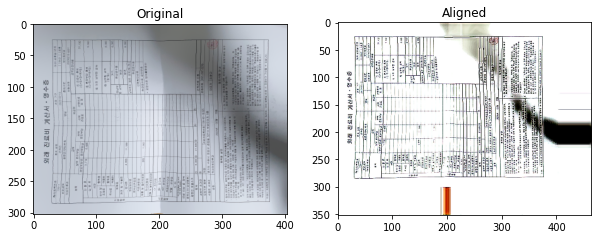

In [97]:
f, axarr = plt.subplots(1,2, figsize=(10,7))

axarr[0].imshow(img)
axarr[0].title.set_text('Original')

axarr[1].imshow(resImg)
axarr[1].title.set_text('Aligned')

In [98]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import skimage.io as io
import numpy as np
import cv2
import glob
import os
from PIL import Image
from PIL import ImageEnhance
import argparse
import warnings
warnings.filterwarnings('ignore')

from DocTr.IllTr import IllTr

In [99]:
import numpy as np
from skimage.filters.rank import mean_bilateral
from skimage import morphology

def reload_model(model, path=""):
    if not bool(path):
        return model
    else:
        model_dict = model.state_dict()
        pretrained_dict = torch.load(path, map_location='cuda:0')
        print(len(pretrained_dict.keys()))
        pretrained_dict = {k[7:]: v for k, v in pretrained_dict.items() if k[7:] in model_dict}
        print(len(pretrained_dict.keys()))
        model_dict.update(pretrained_dict)
        model.load_state_dict(model_dict)

        return model


def padCropImg(img):
    H = img.shape[0]
    W = img.shape[1]

    patchRes = 128
    pH = patchRes
    pW = patchRes
    ovlp = int(patchRes * 0.125)  # 32

    padH = (int((H - patchRes) / (patchRes - ovlp) + 1) * (patchRes - ovlp) + patchRes) - H
    padW = (int((W - patchRes) / (patchRes - ovlp) + 1) * (patchRes - ovlp) + patchRes) - W

    padImg = cv2.copyMakeBorder(img, 0, padH, 0, padW, cv2.BORDER_REPLICATE)

    ynum = int((padImg.shape[0] - pH) / (pH - ovlp)) + 1
    xnum = int((padImg.shape[1] - pW) / (pW - ovlp)) + 1

    totalPatch = np.zeros((ynum, xnum, patchRes, patchRes, 3), dtype=np.uint8)

    for j in range(0, ynum):
        for i in range(0, xnum):
            x = int(i * (pW - ovlp))
            y = int(j * (pH - ovlp))
            
            if j == (ynum-1) and i == (xnum-1):
                totalPatch[j, i] = img[-patchRes:, -patchRes:]
            elif j == (ynum-1):
                totalPatch[j, i] = img[-patchRes:, x:int(x + patchRes)]
            elif i == (xnum-1):
                totalPatch[j, i] = img[y:int(y + patchRes), -patchRes:]
            else:
                totalPatch[j, i] = padImg[y:int(y + patchRes), x:int(x + patchRes)]

    return totalPatch, padH, padW


def illCorrection(model, totalPatch):
    totalPatch = totalPatch.astype(np.float32) / 255.0

    ynum = totalPatch.shape[0]
    xnum = totalPatch.shape[1]

    totalResults = np.zeros((ynum, xnum, 128, 128, 3), dtype=np.float32)

    for j in range(0, ynum):
        for i in range(0, xnum):
            patchImg = torch.from_numpy(totalPatch[j, i]).permute(2,0,1)
            patchImg = patchImg.cuda().view(1, 3, 128, 128)

            output = model(patchImg)
            output = output.permute(0, 2, 3, 1).data.cpu().numpy()[0]

            output = output * 255.0
            output = output.astype(np.uint8)

            totalResults[j, i] = output

    return totalResults


def composePatch(totalResults, padH, padW, img):
    ynum = totalResults.shape[0]
    xnum = totalResults.shape[1]
    patchRes = totalResults.shape[2]

    ovlp = int(patchRes * 0.125)
    step = patchRes - ovlp

    resImg = np.zeros((patchRes + (ynum - 1) * step, patchRes + (xnum - 1) * step, 3), np.uint8)
    resImg = np.zeros_like(img).astype('uint8')

    for j in range(0, ynum):
        for i in range(0, xnum):
            sy = int(j * step)
            sx = int(i * step)
            
            if j == 0 and i != (xnum-1):
                resImg[sy:(sy + patchRes), sx:(sx + patchRes)] = totalResults[j, i]
            elif i == 0 and j != (ynum-1):
                resImg[sy+10:(sy + patchRes), sx:(sx + patchRes)] = totalResults[j, i,10:]
            elif j == (ynum-1) and i == (xnum-1):
                resImg[-patchRes+10:, -patchRes+10:] = totalResults[j, i,10:,10:]
            elif j == (ynum-1) and i == 0:
                resImg[-patchRes+10:, sx:(sx + patchRes)] = totalResults[j, i,10:]
            elif j == (ynum-1) and i != 0:
                resImg[-patchRes+10:, sx+10:(sx + patchRes)] = totalResults[j, i,10:,10:]
            elif i == (xnum-1) and j == 0:
                resImg[sy:(sy + patchRes), -patchRes+10:] = totalResults[j, i,:,10:]
            elif i == (xnum-1) and j != 0:
                resImg[sy+10:(sy + patchRes), -patchRes+10:] = totalResults[j, i,10:,10:]
            else:
                resImg[sy+10:(sy + patchRes), sx+10:(sx + patchRes)] = totalResults[j, i,10:,10:]

    resImg[0,:,:] = 255

    return resImg


def preProcess(img):
    img[:,:,0] = mean_bilateral(img[:,:,0], morphology.disk(20), s0=10, s1=10)
    img[:,:,1] = mean_bilateral(img[:,:,1], morphology.disk(20), s0=10, s1=10)
    img[:,:,2] = mean_bilateral(img[:,:,2], morphology.disk(20), s0=10, s1=10)
    
    return img


def postProcess(img):
    img = Image.fromarray(img)
    enhancer = ImageEnhance.Contrast(img)
    factor = 2.0
    img = enhancer.enhance(factor)

    return img


def rec_ill(img, IllTr_path):
    
    IllTr_model = IllTr().cuda()
    # reload illumination rectification model
    reload_model(IllTr_model, IllTr_path)

    # To eval mode
    IllTr_model.eval()

    print("Time1")
    totalPatch, padH, padW = padCropImg(img)

    print("Time2")
    totalResults = illCorrection(IllTr_model, totalPatch)
    #return totalResults
    print("Time3")
    resImg = composePatch(totalResults, padH, padW, img)
    return totalResults, resImg
    #resImg = postProcess(resImg)
    #resImg = Image.fromarray(resImg)
    #resImg.save(saveRecPath)  


In [140]:
refFilename = "./DocGeoNet/rec/100_rec.png"
img = io.imread(refFilename)

scale_percent = 100 # percent of original size
width = int(img.shape[1] * scale_percent / 100)
height = int(img.shape[0] * scale_percent / 100)
dim = (width, height)
  
# resize image
resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

In [141]:
IllTr_path = "./DocTr/model_pretrained/illtr.pth"
totalResults, resImg = rec_ill(resized, IllTr_path)

186
186
Time1
Time2
Time3


In [142]:
refFilename0 = "./DocGeoNet/distorted/100.jpg"
img0 = io.imread(refFilename0)

In [138]:
img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
resImg = cv2.rotate(resImg, cv2.ROTATE_90_CLOCKWISE)

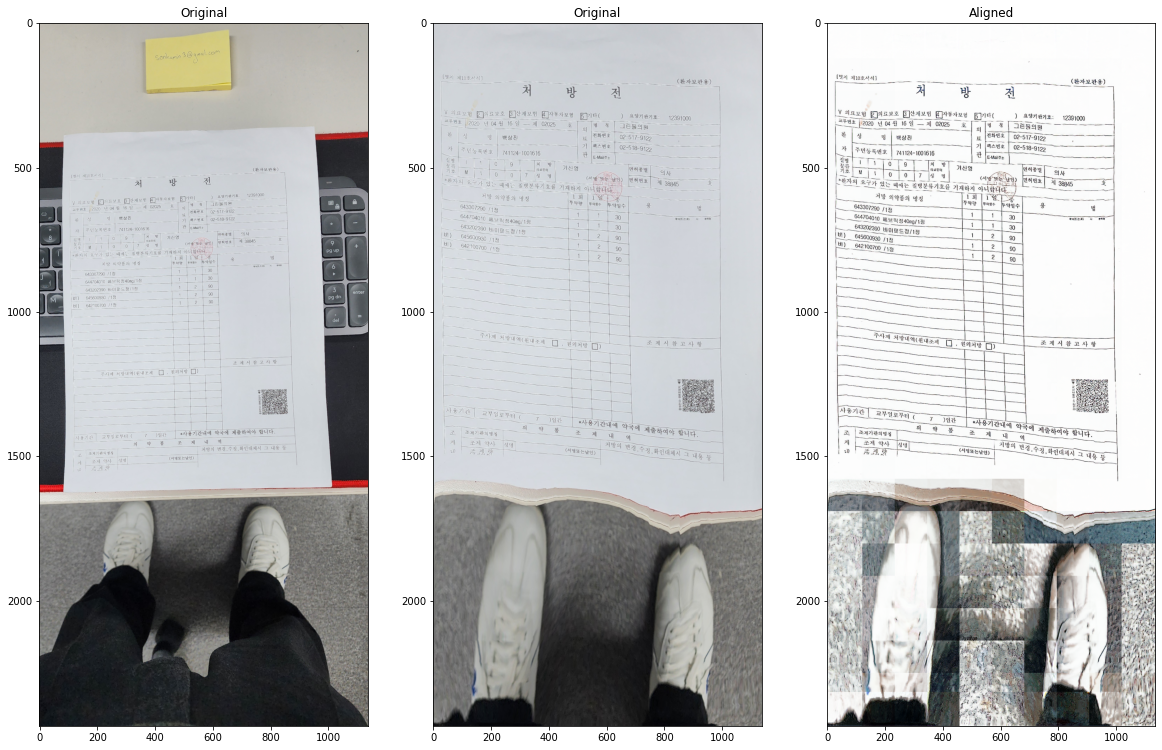

In [143]:

f, axarr = plt.subplots(1,3, figsize=(20,14))

axarr[0].imshow(img0)
axarr[0].title.set_text('Original')


axarr[1].imshow(img)
axarr[1].title.set_text('Original')

axarr[2].imshow(resImg)
axarr[2].title.set_text('Aligned')

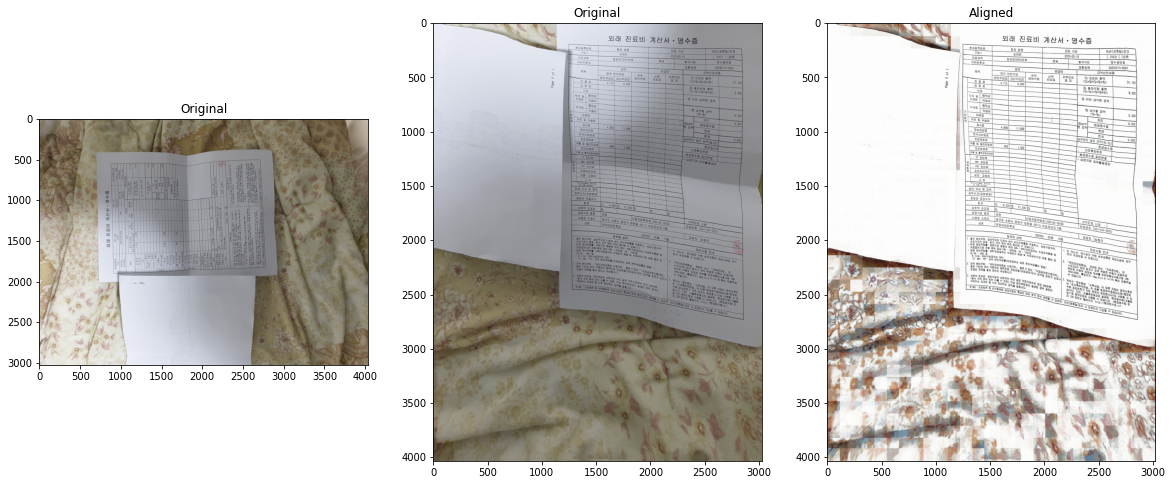

In [139]:

f, axarr = plt.subplots(1,3, figsize=(20,14))

axarr[0].imshow(img0)
axarr[0].title.set_text('Original')


axarr[1].imshow(img)
axarr[1].title.set_text('Original')

axarr[2].imshow(resImg)
axarr[2].title.set_text('Aligned')

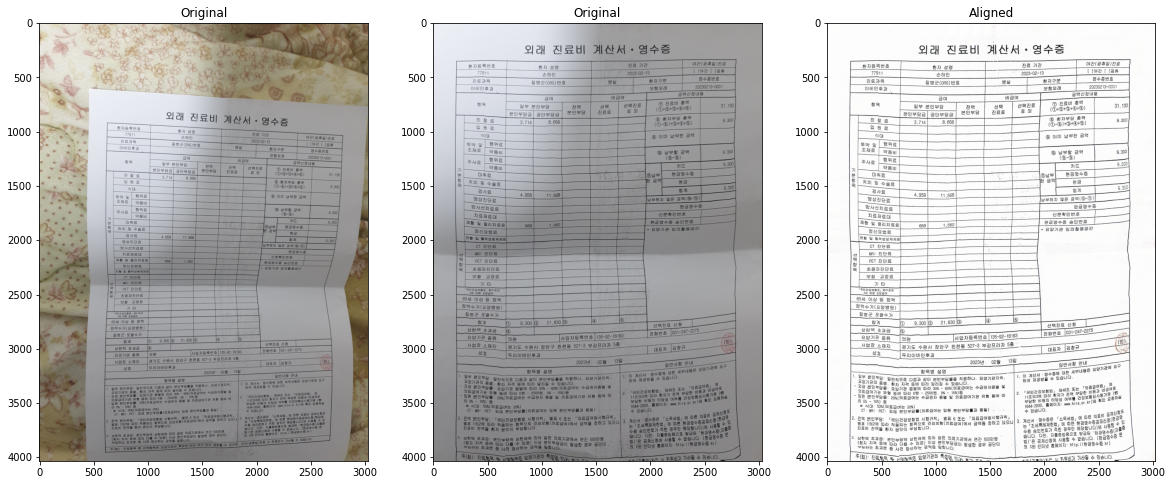

In [134]:

f, axarr = plt.subplots(1,3, figsize=(20,14))

axarr[0].imshow(img0)
axarr[0].title.set_text('Original')


axarr[1].imshow(img)
axarr[1].title.set_text('Original')

axarr[2].imshow(resImg)
axarr[2].title.set_text('Aligned')

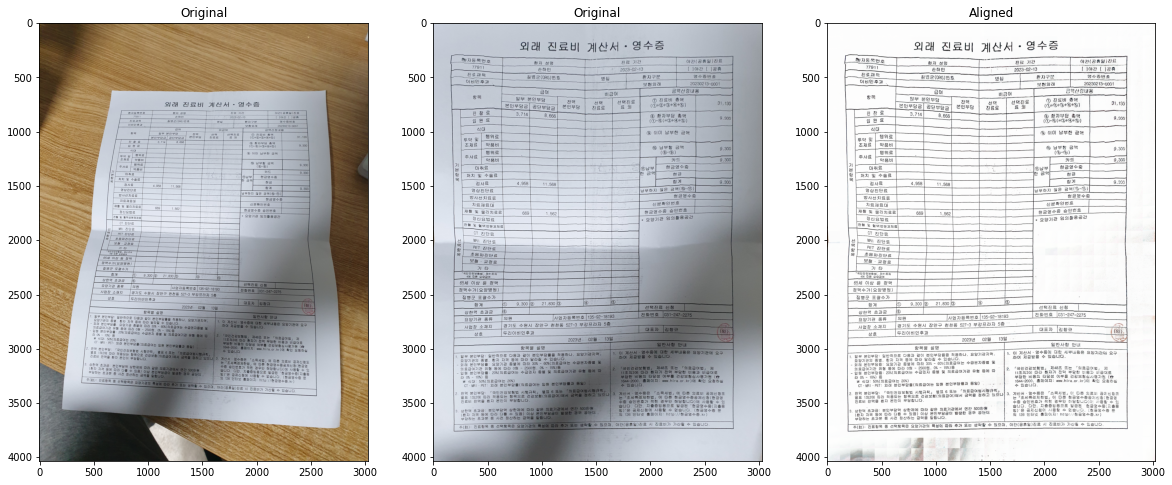

In [127]:

f, axarr = plt.subplots(1,3, figsize=(20,14))

axarr[0].imshow(img0)
axarr[0].title.set_text('Original')


axarr[1].imshow(img)
axarr[1].title.set_text('Original')

axarr[2].imshow(resImg)
axarr[2].title.set_text('Aligned')